<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>    

# Group Number:
# Student 1:
# Student 2:
# Student 3:

In [1]:
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Training data set


For Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains images of handwritten characters of size (28,28). 



For training data, the dataset contains 10000 sets of 6 images each. Each set consists of 5 support images and 1 query image. In each set, the first five columns are support images and the last one is a query image.

For training labels, the dataset contains 10000 sets of 5 binary flags for support images. 1 indicates the same character is given in the query image and 0 means not. For example, a label [1,0,0,1,1] means the support images with index 0,3,4 are the same character of query image.

 
 
The following cell provides code that loads the data from hardcoded URLs.You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 




In [2]:
import matplotlib.pyplot  as plt

In [3]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
#Downloading may take a while..
train_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4OXkVie05NPjRKK/download')
train_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/oMLFw60zpFX82ua/download')

print(f"train_data shape: {train_data.shape}")
print(f"train_label shape: {train_label.shape}\n")

train_data shape: (10000, 6, 28, 28)
train_label shape: (10000, 5)



Now, we plot the first 5 cases in the training dataset. The last column corresponds with the query images of each task. All other images are support images. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the query image. 

In [4]:
def plot_case(caseID,train_data,labels):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    

    support_set,queries = np.split(train_data, [5], axis=1)
  
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))

    # plot anchor image
    axes[5].imshow(queries[caseID, 0])
    axes[5].set_title(f"Query image case {caseID}", fontsize=15)

    # show all test images images 
    [ax.imshow(support_set[caseID, i]) for i, ax in enumerate(axes[0:-1])]


    # Add the patch to the Axes
    for ind in np.where(labels[caseID]==True)[0]:
        axes[ind].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))


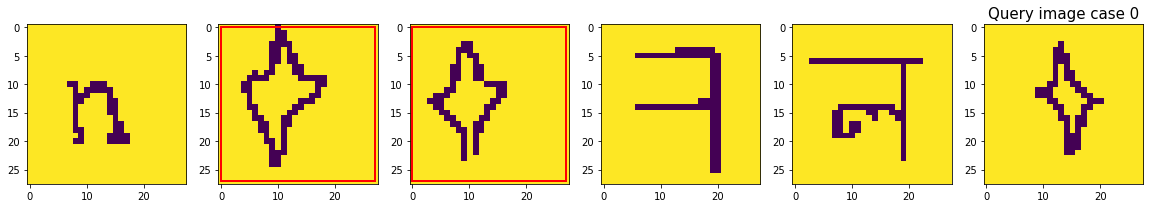

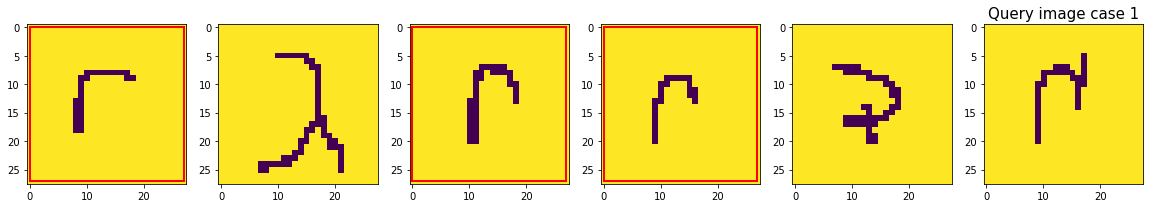

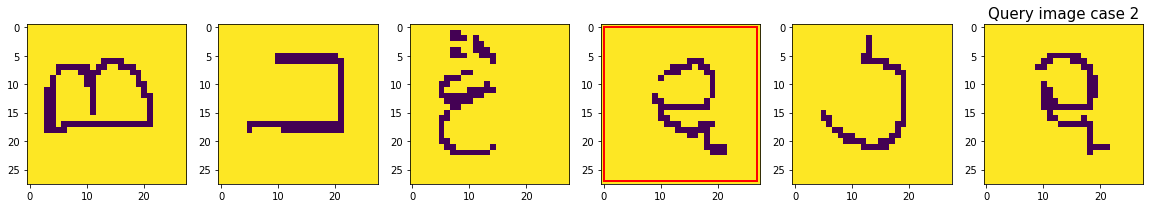

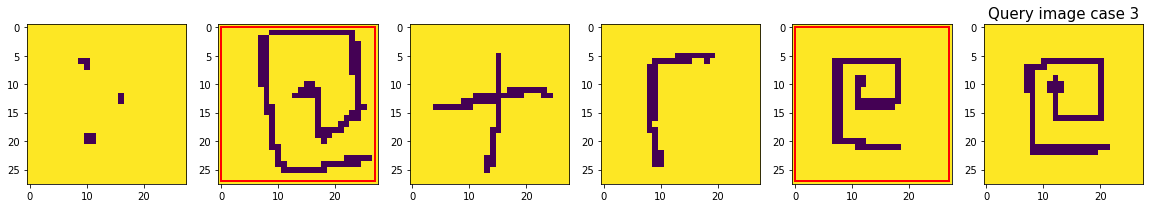

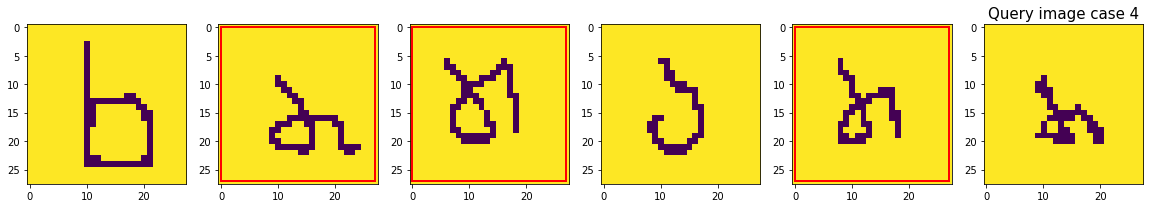

In [5]:
[plot_case(caseID,train_data,train_label) for caseID in range(5)] ;

### Query data set

For this task you need to use the following query data set. The dataset contains 1000 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 


In [6]:
    
#Downloading may take a while..
test_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/06c34QVUr69CxWY/download')
test_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/LQIH1CW7lfDXevk/download')

print(f"test_data shape: {test_data.shape}")
print(f"test_label shape: {test_label.shape}\n")

test_data shape: (1000, 6, 28, 28)
test_label shape: (1000, 5)



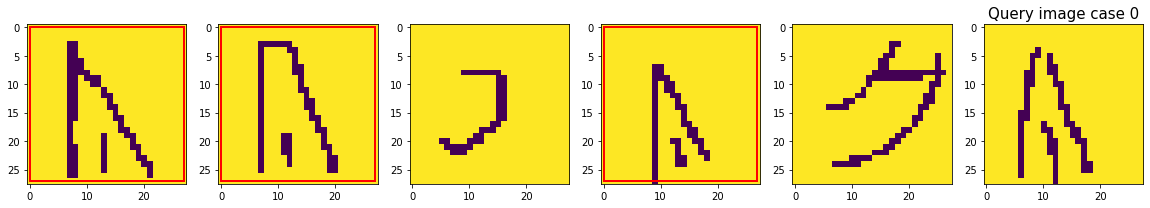

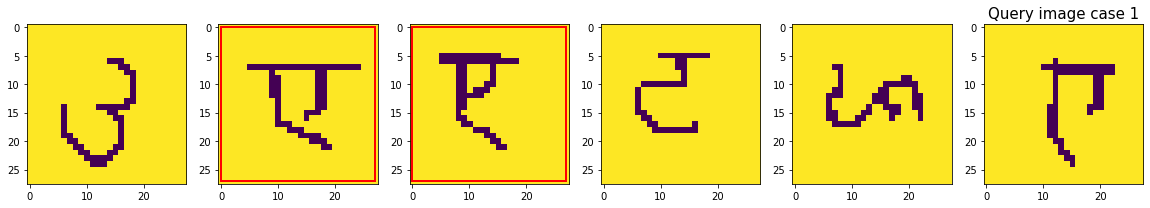

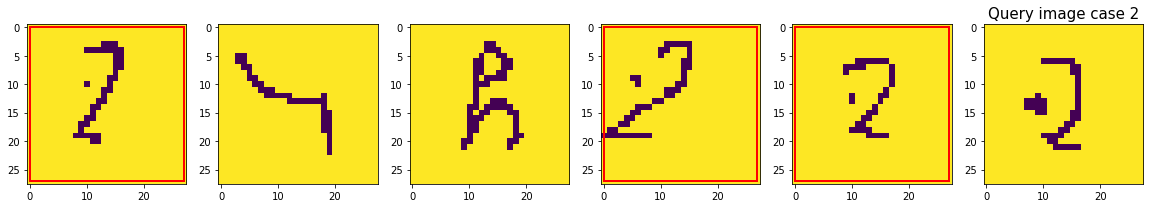

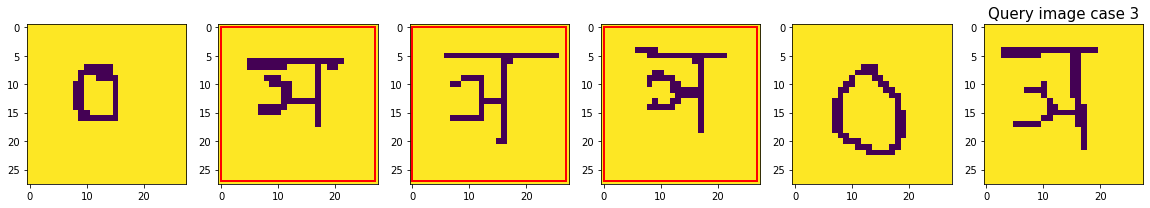

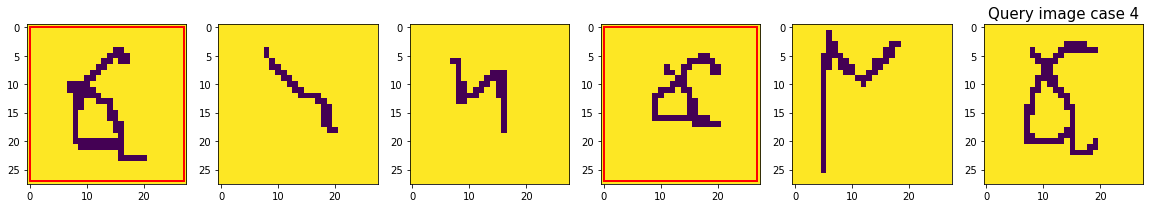

In [7]:
[plot_case(caseID,test_data,test_label) for caseID in range(5)] ;

### Build pytorch dataset and dataload

In [8]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image


class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data)
        self.targets = torch.LongTensor(targets)

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [9]:
# transform = transforms.ToTensor()
train_dataset=MyDataset(train_data,train_label)
test_dataset=MyDataset(test_data,test_label)

In [10]:
print("Training data shape ",train_data.shape)
print("Testing data shape",test_data.shape)

Training data shape  (10000, 6, 28, 28)
Testing data shape (1000, 6, 28, 28)


In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

In [12]:
print(train_loader)

In [13]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [14]:
## Task  ##

In [15]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=3,stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384 * 3 * 3, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        #output1 = output1.view(-1, 256 * 3 * 3)
        output2 = self.forward_once(input2)
        #output2 = output1.view(-1, 256 * 3 * 3)

        return output1, output2

In [16]:
#Different network structures, the commented out are the different experimenting structures
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Conv2d(input_channels, output_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 4, 3) 
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.conv3 = nn.Conv2d(8, 8, 3)
       
        self.bn1 = nn.BatchNorm2d(4)
        self.bn2 = nn.BatchNorm2d(8)
        self.bn3 = nn.BatchNorm2d(8)
        
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.4)
        self.f_connected1 = nn.Linear(8 * 3 * 3, 500)
        self.f_out = nn.Linear(500, 1)
        self.sigmoid = nn.Sigmoid()

    def forward_once(self, x):
        
        # out_dim = in_dim - kernel_size + 1  
        #1, 28,
       
        x = F.relu(self.bn1(self.conv1(x)))
        # 32, 26, 26
        x = F.max_pool2d(x, (2,2))
        # 32, 13, 13
        x = self.dropout2(x)
        x = F.relu(self.bn2(self.conv2(x)))
        # 64, 11, 11
        x = F.max_pool2d(x, (2,2))
        # 64, 5, 5
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout2(x)
        # 128, 3, 3
       
        return x

    def forward(self, input1,input2 ):
        
        input1 = self.forward_once(input1)
        input1 = input1.view(-1, 8 * 3 * 3)
        #input1= self.sigmoid(self.f_connected1(input1))
  
        input2 = self.forward_once(input2)

        input2 = input2.view(-1, 8 * 3 * 3)
        #input2= self.sigmoid(self.f_connected1(input2))
        #x = torch.abs(input1 - input2)
        #x = self.f_out(x)
        
        return input1,input2


In [17]:
## LOSS Definition ##

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [18]:
#creating the original network and couting the paramenters of different networks
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
siameseNet = SiameseNetwork()
siameseNet = siameseNet.to(device)

def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(siameseNet)

The model architecture:

 SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=3456, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

The model has 4,910,402 trainable parameters


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys


In [19]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer):
    save_path = f'siameseNet-batchnorm50.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

In [20]:
trans = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Grayscale()
])

In [26]:
# training and validation after every epoch
def train(model, train_loader, val_loader, num_epochs, criterion, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    cur_step = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for train_data, labels in train_loader:
            #plot_case(99,train_data,labels)
            support_set, queries = np.split(train_data, [5], axis=1)
            labels = torch.tensor_split(labels, 5, dim=1)
            # Forward
            case_loss = 0.0
            for x in range(5):
                img1 = queries.to(device)
                x2 = support_set[:,x]
                img2 = x2.view(-1,1,28,28).to(device)
                #print("support", x2.shape)
                #break
                #img2 = support_set.to(device)
                #labels = labels[:,[0][4]].view(-1,1).to(device)
                #print(labels[4].shape)
                output1,output2 = model(img1, img2)
                loss = criterion(output1,output2, labels[x].float().to(device))
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                case_loss += loss.item()

            case_loss = case_loss/5
            running_loss += case_loss

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for val_data, labels in test_loader:
                support_set, queries = np.split(val_data, [5], axis=1)
                labels = torch.tensor_split(labels, 5, dim=1)
                case_loss = 0.0
                for x in range(5):
                    img1 = queries.to(device)
                    #img2 = support_set.to(device)
                    x2 = support_set[:,x]
                    img2 = x2.view(-1,1,28,28).to(device)
                    #labels = labels[:,x].view(-1,1).to(device)
                    output1,output2 = model(img1, img2)
                    loss = criterion(output1,output2, labels[x].float().to(device))
                    case_loss += loss.item()

                case_loss = case_loss/5
                val_running_loss += case_loss

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)
    
    print("Finished Training")  
    return train_losses, val_losses  


def eval(model, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        print('Starting Iteration')
        count = 0
        for test_data, labels in test_loader:
            support_set, queries = np.split(test_data, [5], axis=1)
            queries = queries.to(device)
            #print(labels)
            predVal = 0
            pred = []
            for i in range(5):
                x2 = support_set[:,i]
                testImg = x2.view(-1,1,28,28).to(device)
                #print(testImg.shape)
                #output = model(queries, testImg)
                output1,output2 = model(queries, testImg)
                #output=torch.abs(output1 - output2)
                #loss = criterion(output1,output2, labels[i].float().to(device))
                #print(output)
                if output > 0:
                    pred.append(1)
                else:
                    pred.append(0)
            # print(labels[0])
            # print(torch.tensor(pred))
            if torch.eq(labels[0], torch.tensor(pred)).all():
                correct += 1
            count += 1
            if count % 100 == 0:
                print("Current Count is: {}".format(count))
                print('Accuracy on 5 way 1-shot: {}'.format(correct/count))

In [22]:
# actual training
import torch.optim as optim
#from pytorch_metric_learning import losses

optimizer = optim.Adam(siameseNet.parameters(), lr = 0.0006)
num_epochs = 50
#criterion = nn.BCEWithLogitsLoss()

criterion=ContrastiveLoss()

save_path = 'siameseNet-batchnorm50.pt'
train_losses, val_losses = train(siameseNet, train_loader, test_loader, num_epochs, criterion, save_path)

Starting epoch 1
Epoch [1/50],Train Loss: 1.1671, Valid Loss: 1.12762955
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 2
Epoch [2/50],Train Loss: 1.1216, Valid Loss: 1.11222653
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 3
Epoch [3/50],Train Loss: 1.0772, Valid Loss: 1.09953943
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 4
Epoch [4/50],Train Loss: 1.0407, Valid Loss: 1.10819702
Starting epoch 5
Epoch [5/50],Train Loss: 1.0015, Valid Loss: 1.11951881
Starting epoch 6
Epoch [6/50],Train Loss: 0.9661, Valid Loss: 1.13126296
Starting epoch 7
Epoch [7/50],Train Loss: 0.9316, Valid Loss: 1.15735373
Starting epoch 8
Epoch [8/50],Train Loss: 0.8993, Valid Loss: 1.17810426
Starting epoch 9
Epoch [9/50],Train Loss: 0.8764, Valid Loss: 1.20975322
Starting epoch 10
Epoch [10/50],Train Loss: 0.8544, Valid Loss: 1.23837438
Starting epoch 11
Epoch [11/50],Train Loss: 0.8292, Valid Loss: 1.24321263
Starting epoch 12
Epoch [12/50],Train Loss: 0.8093, Valid 

In [27]:
## Evaluation ##
import torch.optim as optim
load_model = SiameseNetwork().to(device)
load_optimizer = optim.Adam(load_model.parameters(), lr=0.0006)


num_epochs = 10
eval_every = 1000
total_step = len(train_loader)*num_epochs
best_val_loss = load_checkpoint(load_model, load_optimizer)

print(best_val_loss)
eval(load_model, test_loader)

Model loaded from <== siameseNet-batchnorm50.pt
1.0995394311845303
Starting Iteration


RuntimeError: ignored